In [2]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
def gaussian_kernel(X, Y, sigma=1.0):
    pairwise_sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    return K


In [4]:
def center_kernel(K):
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - np.dot(one_n, K) - np.dot(K, one_n) + np.dot(one_n, np.dot(K, one_n))
    return K_centered

In [5]:
def scatter_matrices(K_centered, y):
    classes = np.unique(y)
    n_classes = len(classes)
    n_samples = len(y)
    Sw = np.zeros_like(K_centered)
    Sb = np.zeros_like(K_centered)
    
    for c in classes:
        class_idx = (y == c)
        class_size = np.sum(class_idx)
        class_kernel = K_centered[class_idx]
        Sw += np.dot(class_kernel.T, class_kernel) / class_size
    
    total_mean = np.mean(K_centered, axis=0)
    for c in classes:
        class_idx = (y == c)
        class_size = np.sum(class_idx)
        class_mean = np.mean(K_centered[class_idx], axis=0)
        Sb += class_size * np.outer(class_mean - total_mean, class_mean - total_mean)
    
    return Sw, Sb


In [6]:
def compute_eigens(Sw, Sb, n_components):
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvectors[:, :n_components]


In [7]:
class KernelLDA:
    def __init__(self, kernel='rbf', sigma=1.0, n_components=None):
        self.kernel = kernel
        self.sigma = sigma
        self.n_components = n_components
    
    def fit(self, X, y):
        self.X_train = X
        if self.kernel == 'rbf':
            self.kernel_func = gaussian_kernel
        else:
            raise ValueError("Unsupported kernel type!")
        
        K = self.kernel_func(X, X, sigma=self.sigma)
        K_centered = center_kernel(K)
        Sw, Sb = scatter_matrices(K_centered, y)
        self.eigenvectors = compute_eigens(Sw, Sb, self.n_components)
    
    def transform(self, X):
        K = self.kernel_func(X, self.X_train, sigma=self.sigma)
        return np.dot(K, self.eigenvectors)


(200, 1)
1.5976201166409736
-1.6244333840590464
float64


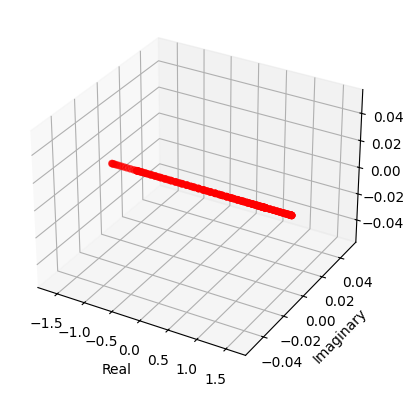

IndexError: index 1 is out of bounds for axis 1 with size 1

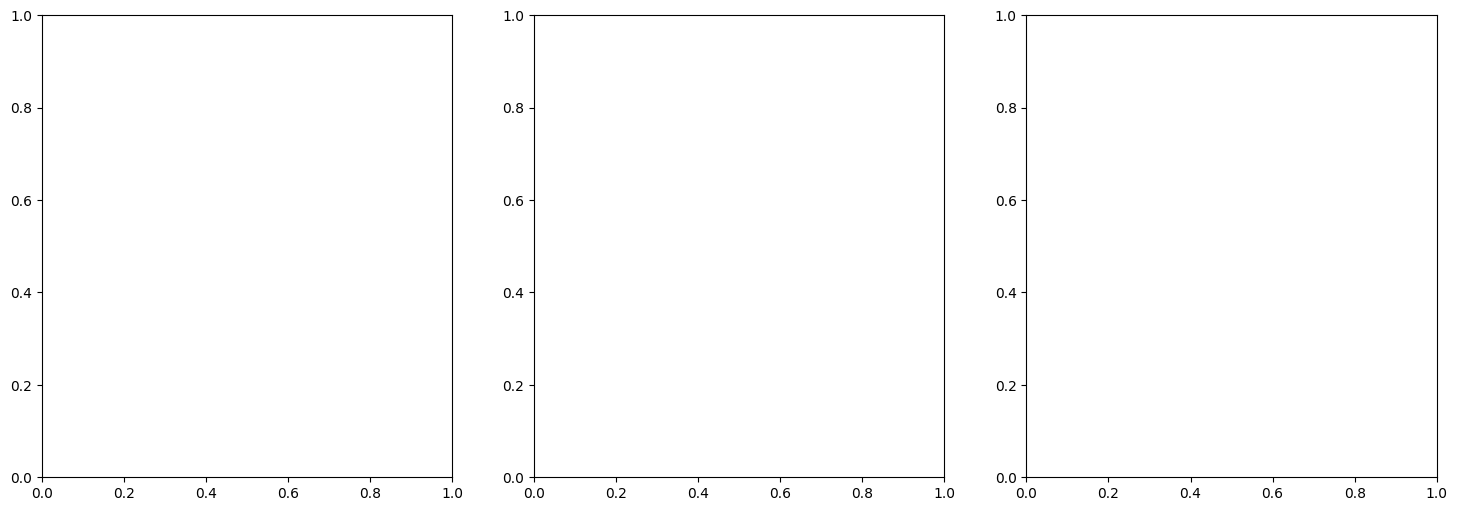

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Generate circular data for two classes
def generate_circular_data(n_samples, radius):
    angles = np.linspace(0, 2*np.pi, n_samples)
    X = np.array([radius*np.cos(angles), radius*np.sin(angles)]).T
    return X

# Generate two classes of circular data
n_samples = 100
radius = 5
X_class1 = generate_circular_data(n_samples, radius)
X_class2 = generate_circular_data(n_samples, radius + 2) # Second class is outer circle

X_data = np.vstack([X_class1, X_class2])
y_data = np.array([[0]*100 + [1]*100]).T.flatten()

kernel_lda = KernelLDA(kernel='rbf', sigma=1.0, n_components=3)
kernel_lda.fit(X_data, y_data)

X_transformed = kernel_lda.transform(X_data)

kernel_lda = LinearDiscriminantAnalysis(n_components=1)
kernel_lda.fit(X_data, y_data)

X_transformed = kernel_lda.transform(X_data)


print(X_transformed.shape)
print(np.max(X_transformed))
print(np.min(X_transformed))
print(X_transformed.dtype)


# Separate real and imaginary parts
real_part = X_transformed.real
imaginary_part = X_transformed.imag

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the data
# ax.scatter(real_part, imaginary_part, np.zeros_like(real_part), c='r', marker='o')

# # Set labels
# ax.set_xlabel('Real')
# ax.set_ylabel('Imaginary')
# ax.set_zlabel('')

# # Show the plot
# plt.show()



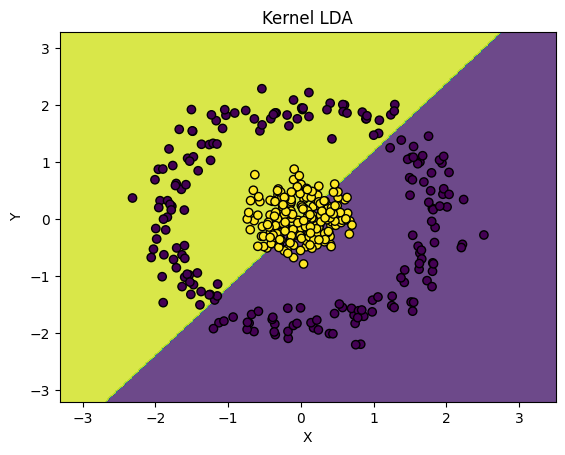

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline


X, y = make_circles(n_samples=400, noise=0.1, factor=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


lda = LinearDiscriminantAnalysis(n_components=1)


pipeline = Pipeline([('lda', lda)])


pipeline.fit(X_scaled, y)


h = 0.02
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k')
plt.title('Kernel LDA')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

(111150, 368)


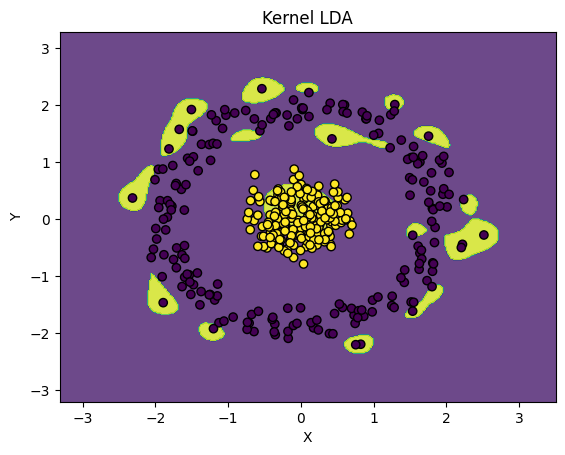

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline


X, y = make_circles(n_samples=400, noise=0.1, factor=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kpca = KernelPCA(kernel="rbf", gamma=10)
X_kpca = kpca.fit_transform(X_scaled)


lda = LinearDiscriminantAnalysis(n_components=1)


pipeline = Pipeline([('kpca', kpca), ('lda', lda)])


pipeline.fit(X_scaled, y)


h = 0.02
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


Z = kpca.transform(np.c_[xx.ravel(), yy.ravel()])
print(Z.shape)
Z = lda.predict(Z)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k')
plt.title('Kernel LDA')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
